In [1]:
import pandas as pd
import numpy as np

In [2]:
# loading the dataset from csv
raw = pd.read_csv(
    "../dataset/anonymous-msweb.data", 
    names=['attribute', 'ID', 'ignore', 'title', 'url'], 
    engine="python", 
    skiprows=7
)
raw.head()

,attribute,ID,ignore,title,url
0,A,1287,1,International AutoRoute,/autoroute
1,A,1288,1,library,/library
2,A,1289,1,Master Chef Product Information,/masterchef
3,A,1297,1,Central America,/centroam
4,A,1215,1,For Developers Only Info,/developer


In [3]:
# Filtering the data needed and printing the type of data present
data = raw[['attribute', 'ID', 'title', 'url']]
data.groupby(by='attribute').count()

,ID,title,url
attribute,,,
A,294,294,294
C,32711,0,0
V,98654,0,0


In [4]:
# Printing all the attribute lines
attributes = data[data['attribute'] == 'A']
attributes = attributes[['ID', 'title', 'url']]
attributes.head()

,ID,title,url
0,1287,International AutoRoute,/autoroute
1,1288,library,/library
2,1289,Master Chef Product Information,/masterchef
3,1297,Central America,/centroam
4,1215,For Developers Only Info,/developer


In [5]:
# Printing the websites and the users
websites = data[data['attribute'] == 'V']
users = data[data['attribute'] == 'C']
print("Websites")
print(websites.head())
print("\nUsers")
print(users.head())

Websites
    attribute    ID title   url
295         V  1000  None  None
296         V  1001  None  None
297         V  1002  None  None
299         V  1001  None  None
300         V  1003  None  None

Users
    attribute     ID title   url
294         C  10001  None  None
298         C  10002  None  None
301         C  10003  None  None
305         C  10004  None  None
307         C  10005  None  None


In [6]:
# Count the website visits
website_visits = websites[['ID', 'attribute']].groupby(by='ID').count()
website_visits.columns=['visits']
website_visits.sort_values(by='visits', ascending=False)
website_visits = pd.merge(website_visits, attributes, left_index=True, right_on="ID")
website_visits.sort_values(by='visits', ascending=False).head()

,visits,ID,title,url
57,10836,1008,Free Downloads,/msdownload
283,9383,1034,Internet Explorer,/ie
17,8463,1004,Microsoft.com Search,/search
287,5330,1018,isapi,/isapi
212,5108,1017,Products,/products


          url  visits
268   /regwiz     912
78   /support    4451
217   /athome     749
30        /kb    2968
17    /search    8463


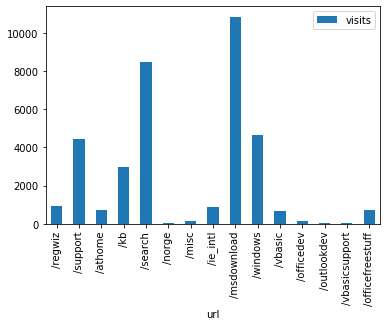

In [7]:
%matplotlib inline 
pd.set_option('display.width', 10000) 
pd.set_option('display.max_columns', 80) 
webiste_visis_plot = website_visits[['url', 'visits']]
print(webiste_visis_plot.head())
webiste_visis_plot[:15].plot(kind='bar', x='url', y='visits')

In [8]:
# Print the websites with 100 visits or more which will be called as popular_websites
popular_websites = website_visits[website_visits['visits'] >= 100]
print(popular_websites.shape)
popular_websites.head()

(104, 4)


,visits,ID,title,url
268,912,1000,regwiz,/regwiz
78,4451,1001,Support Desktop,/support
217,749,1002,End User Produced View,/athome
30,2968,1003,Knowledge Base,/kb
17,8463,1004,Microsoft.com Search,/search


In [9]:
# user_webvisits is the user + web visit data
user_webvisits = raw[raw['attribute'] != 'A']
print(user_webvisits.shape)
user_webvisits = user_webvisits[['attribute', 'ID']]
webvisits = []
user = ''
for row in user_webvisits.values:
    if row[0] == 'C':
        user = row[1]
    elif row[0] == 'V':
        webvisits.append([user, row[1]])
        
webvisits = pd.DataFrame(webvisits, columns=['user', 'ID'])
webvisits.head()

(131365, 5)


,user,ID
0,10001,1000
1,10001,1001
2,10001,1002
3,10002,1001
4,10002,1003


In [10]:
# Merging the user, webvisits and URL data
attributes = pd.merge(attributes, popular_websites, on="ID")
attributes = attributes[['ID', 'visits', 'title_x', 'url_x']]
attributes.columns = ['ID', 'visits', 'title', 'url']
attributes.sort_values(by='ID').head()
data = pd.merge(webvisits, attributes, on="ID")
data['values'] = 1
data.sort_values(by='user').head()

,user,ID,visits,title,url,values
0,10001,1000,912,regwiz,/regwiz,1
912,10001,1001,4451,Support Desktop,/support,1
5363,10001,1002,749,End User Produced View,/athome,1
913,10002,1001,4451,Support Desktop,/support,1
6112,10002,1003,2968,Knowledge Base,/kb,1


# Item based collaborative filtering

In [11]:
# Forming the item utility matrix
item_utility_matrix = data.pivot(index='user', columns='url', values='values').fillna(value=0)
item_utility_matrix.head()

url,/access,/accessdev,/activeplatform,/activex,/athome,/australia,/automap,/backoffice,/brasil,/canada,/catalog,/cio,/clipgallerylive,/corpinfo,/education,/excel,/exchange,/france,/frontpage,/gallery,/games,/gamessupport,/germany,/homeessentials,/ie,/ie_intl,/iesupport,/iis,/imagecomposer,/industry,/intdev,/intranet,/isapi,/isp,/italy,/java,/jobs,/kb,/kids,/macoffice,...,/officereference,/organizations,/outlook,/powerpoint,/products,/promo,/proxy,/publisher,/referral,/regwiz,/sbnmember,/search,/security,/sitebuilder,/smallbiz,/spain,/sports,/sql,/support,/supportnet,/sverige,/syspro,/taiwan,/train_cert,/truetype,/uk,/usa,/vbasic,/vbscript,/vinterdev,/visualc,/visualj,/vstudio,/win32dev,/windows,/windows95,/windowsce,/windowssupport,/word,/workshop
user,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10001,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Recommending similar items to URL '/athome'
item = item_utility_matrix['/athome']
similarItems = item_utility_matrix.corrwith(item)
similarItems.sort_values(ascending=False).head()

url
/athome            1.000000
/support           0.076860
/windowssupport    0.067837
/moneyzone         0.056557
/windows           0.050309
dtype: float64

# User based collaborative filtering

In [13]:
# Forming the user utility matrix
user_utility_matrix = item_utility_matrix.T
user_utility_matrix.head()

user,10001,10002,10003,10005,10006,10007,10008,10009,10010,10011,10012,10013,10014,10015,10016,10017,10018,10019,10020,10021,10022,10023,10024,10025,10026,10027,10028,10029,10030,10031,10032,10033,10034,10035,10036,10037,10038,10039,10040,10041,...,42672,42673,42674,42675,42676,42677,42678,42679,42680,42681,42682,42683,42684,42685,42686,42687,42688,42689,42690,42691,42692,42693,42694,42695,42696,42697,42698,42699,42700,42701,42702,42703,42704,42705,42706,42707,42708,42709,42710,42711
url,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
/access,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
/accessdev,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
/activeplatform,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
/activex,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
/athome,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# Similar users to user 10011
u = 10011
user = user_utility_matrix[u]
similarUsers = user_utility_matrix.corrwith(user, axis='index').dropna().sort_values(ascending=False)
similarUsers.drop(u, inplace=True)
similarUsers.head()

user
21000    0.74000
16662    0.70014
17563    0.70014
37130    0.70014
21724    0.70014
dtype: float64

In [15]:
# Similar users recommended URLs
df = pd.DataFrame(similarUsers)
users = pd.DataFrame(user_utility_matrix[df.iloc[0].name])
users.columns=['visited']
users = users[users['visited'] == 1]
recommended_websites = pd.merge(users, popular_websites, left_index=True, right_on="url")
recommended_websites = recommended_websites.sort_values(by='visits', ascending=False)
recommended_websites.head()

,visited,visits,ID,title,url
287,1.0,5330,1018,isapi,/isapi
212,1.0,5108,1017,Products,/products
78,1.0,4451,1001,Support Desktop,/support
138,1.0,287,1016,MS Excel,/excel


In [16]:
# Recommending the website to user which he or she has not visited
website_urls = recommended_websites['url']
visited_sites = pd.DataFrame(user[user == 1])
print('Similar users urls for recommendation:', list(website_urls))
print('URLs visited by user:', list(visited_sites.index.values))
print('Recommended websites:', list(set(website_urls).difference(set(visited_sites.index.values))))


Similar users urls for recommendation: ['/isapi', '/products', '/support', '/excel']
URLs visited by user: ['/excel', '/isapi', '/mspowerpoint', '/products']
Recommended websites: ['/support']


In [17]:
# Recommend a user without history with the top visited websites
new_user_recommendations = popular_websites.sort_values(by='visits', ascending=False).head()
list(new_user_recommendations['url'])

['/msdownload', '/ie', '/search', '/isapi', '/products']